# Formatos de Representación para Matrices Dispersas

En este notebook se presentan varios formatos de representación para matrices dispersas. El objetivo detrás del estudio de diferentes formatos para almacenar matrices disperas es optimizar la utilización de la memoria del sistema en algunas operaciones fundamentales sin comprometer el rendimiento, en particular veremos la multiplicación matriz-vector dispersa o _SpMV_.

## Setup

In [1]:
!rm -rf sparse_matrices && git clone https://github.com/santiago-imelio/sparse_matrices.git

Cloning into 'sparse_matrices'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 43 (delta 18), reused 38 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 88.27 KiB | 5.52 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [2]:
!pip install pygments

from IPython.display import Code, HTML
from pygments.styles import get_style_by_name
from pygments.lexers import get_lexer_by_name
from pygments.lexers import CLexer
from pygments import highlight
from pygments.formatters import HtmlFormatter

def show_c_code(path_to_file):
  monokai = get_style_by_name('monokai')
  code = Code(path_to_file).data

  display(HTML(highlight(code, CLexer(), HtmlFormatter(style=monokai, full=True))));

## Compressed Sparse Row (CSR)

CSR se considera como el formato de facto para almacenar y manipular matrices dispersas. Consiste en una estructura de datos que tiene tres arrays:
- `values` es una lista de largo `nnz` tal que `nnz` es la cantidad de elementos no nulos en la matriz. `values` está ordenada en _row-major_.
- `col_index` es una lista de largo `nnz` donde cada elemento `col_index[i]` es el índice de columna correspondiente a `values[i]`.
- `row_ptr` es una lista de largo `m + 1` donde `m` es la cantidad de filas. `row_ptr[i]` es el índice en la lista `col_index` que indica la posición del primer elemento no nulo en la fila `i`. Es decir, `col_index[row_ptr[i]]` es la columna del primer elemento no nulo de la fila `i`.

In [3]:
show_c_code('sparse_matrices/csr/csr.h')

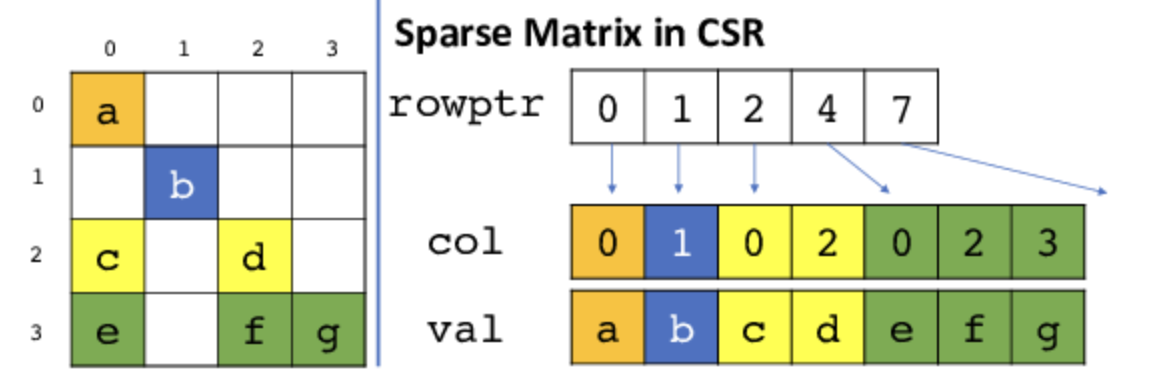

Consideremos la siguiente multiplicación matriz-vector.

\begin{align*}
\begin{bmatrix}
5 & 1 & 7 & 0 & 0 \\
0 & 1 & 0 & 2 & 3 \\
0 & 2 & 4 & 0 & 0 \\
0 & 0 & 1 & 3 & 0 \\
0 & 6 & 0 & 0 & 3
\end{bmatrix}
\begin{bmatrix}
0 \\
1 \\
2 \\
3 \\
4
\end{bmatrix}
\end{align*}

A continuación se muestra el código para realizar la multiplicación matriz vector utilizando formato CSR

In [4]:
show_c_code('sparse_matrices/csr/csr.c')

Si bien este formato de matriz dispersa es ampliamente utilizado, presenta algunas desventajas.

En primer lugar, el algoritmo de `spmv_csr` padece de **accesos a memoria irregulares**. Nótese que al calcular `x[i]` accedemos al vector `v` mediante el índice de columna `col`, el cual se obtiene mediante `row_ptr[i]`. Los índices almacenados en `row_ptr` tienen una naturaleza irregluar, ya que a prori no sabemos cuantos elementos no nulos tiene cada fila de la matriz. Por lo tanto, los accesos a `v` serán irregulares. Esto resulta en mala utilización de la memoria de acceso rápido como el caché y los registros.

Por otra parte, es posible implementar el algoritmo de `spmv_csr` de forma paralela, ya que cada fila de la matriz se puede procesar independientemente de las otras. Sin embargo, el acceso irregular a memoria también causaría un cuello de botella en este caso, por lo que no sería recomendable utilizar CSR para implementar SpMV paralelo,

In [5]:
!gcc sparse_matrices/csr/csr_demo.c sparse_matrices/csr/csr.c -o csr_demo && ./csr_demo

15.0 19.0 10.0 11.0 18.0 

## Blocked Compressed Sparse Row (BCSR)

El formato BCSR fue propuesto por Ali Pinar en su artículo "_Improving Performance of Sparse Matrix-Vector Multiplication_" apunta a mejorar la eficiencia en el uso de memoria de CSR. Está diseñada para reducir la cantidad de operaciones `LOAD`. Consiste en una estructura similar a CSR, pero que incluye otro array adicional:
- `values` es una lista de largo `nnz` tal que `nnz` es la cantidad de elementos no nulos en la matriz. `values` está ordenada en _row-major_.
- `col_index` es una lista de largo `n_blocks` donde `n_blocks` es la cantidad de bloques utilizados para subdividir la matriz. Cada elemento `col_index[i]` es el índice de columna correspondiente al primer elemento no nulo del bloque `i`.
- `row_ptr` es una lista de largo `m + 1` donde `m` es la cantidad de filas. `row_ptr[i]` es el índice en la lista `col_index` que indica la posición del primer elemento no nulo en la fila `i`. Es decir, `col_index[row_ptr[i]]` es la columna del primer elemento del primer bloque en la fila `i`.
- `nz_ptr` es una lista de largo `n_blocks + 1` donde cada elemento `nz_ptr[i]` almacena el índice en la lista `values` correspondiente al primer elemento del bloque `i`. Es decir, `values[nz_ptr[i]]` es el elemento de la matriz en la primera posición del bloque `i`.

In [6]:
show_c_code('sparse_matrices/bcsr/bcsr.h')

Con esta representación los accesos a la memoria se regularizan un poco más, especialmente el acceso a los elementos del vector `v`. Nótese que para calcular `xi` se iteran sobre los bloques de la fila `i` y luego sobre los elementos de cada bloque. Como los bloques tienen elementos contiguos, los accesos a `v` por bloque también seran contiguos.

In [7]:
show_c_code('sparse_matrices/bcsr/bcsr.c')

In [8]:
!gcc sparse_matrices/bcsr/bcsr_demo.c sparse_matrices/bcsr/bcsr.c -o bcsr_demo && ./bcsr_demo

15.0 19.0 10.0 11.0 18.0 

## Mapped Blocked Row (MBR)

El formato MBR fue propuesto por Ramaseshan Kannan en su artículo "_Efficient sparse matrix multiple-vector multiplication using a bitmapped format_". La motivación detrás de MBR era obtener las mejoras en el uso de registros de la versión de BCSR que menciona Kannan en su artículo, sin las penalizaciones en performance.

La idea central del formato MBR es representar los bloques de BSR como una combinación de los elementos del bloque y un mapa de bits que refleja la estructura del bloque:

\begin{align*}
\begin{bmatrix}
a_{11} & a_{22} \\
0 & 0
\end{bmatrix}
\implies
\begin{bmatrix}
a_{11} & a_{22}
\end{bmatrix}
+
\begin{bmatrix}
1 & 1 \\
0 & 0
\end{bmatrix}
\end{align*}

El mapa de bits se puede leer como un número binario, leyendolo de derecha a izquierda y de abajo hacia arriba, siendo el bit más significativo el de abajo a la derecha, y el bit menos significativo el de arriba a la izquierda. Por tanto, el mapa de bits de un bloque se puede almacenar en su representación decimal.

El formato MBR consiste en los siguientes campos:
- `r` es la cantidad de filas en cada bloque
- `c` es la cantidad de columnas en cada bloque
- `values` es una lista de largo `nnz` tal que `nnz` es la cantidad de elementos no nulos en la matriz. `values` está ordenada en _row-major_ de acuerdo a cada bloque. Es decir, $[B_1, B_2, ..., B_n]$ siendo $B_i$ la lista de elementos del $i$-ésimo bloque denso ordenada en row-major.
- `col_index` es una lista de largo `n_blocks` donde cada elemento `col_index[i]` es el índice del bloque `i` en el eje $x$ de la matriz original.
- `row_ptr` es una lista de largo `block_rows + 1` donde `block_rows` es la cantidad de filas "a bloques". `row_ptr[i]` es el índice en la lista `col_idx` tal que la tupla `(i, col_idx[row_ptr[i]])` son las coordenadas $(x, y)$ del bloque `i` en la matriz a bloques.
- `bit_map` es una lista de largo `n_blocks` donde cada elemento `bit_map[i]` es la representación decimal del bitmap linearizado del bloque `i`.

In [9]:
show_c_code('sparse_matrices/mbr/mbr.h')

In [10]:
show_c_code('sparse_matrices/mbr/mbr.c')

En el siguiente demo se le agregó una fila y una columna con los elementos en cero a la matriz original utilizada en los ejemplos anteriores. Esto es para poder trabajar con una matriz de 6 por 6 y que se pueda dividir en 9 bloques de 2 por 2.

In [11]:
!gcc sparse_matrices/mbr/mbr_demo.c sparse_matrices/mbr/mbr.c -o mbr_demo && ./mbr_demo

15.0 19.0 10.0 11.0 18.0 0.0 